<a href="https://colab.research.google.com/github/TMKarunarathne/FYP/blob/main/(10min)svr_with_mean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

rand_state =1000
mat_file = '/content/gdrive/MyDrive/Data_Set/FV_10000x8928_01.mat'

mat = scipy.io.loadmat(mat_file)

Mounted at /content/gdrive
Mounted at /content/gdrive


In [ ]:
df1= pd.DataFrame(mat['df'])
df1 = df1.drop(df1.columns[[0]], axis=1)
df1=df1.iloc[:,1:]
col = [i for i in range(1,10001)]
df1 = df1.set_axis(col, axis=1)
dates_x = pd.to_datetime(pd.DataFrame(mat['df'])[1], unit="s")
df1.set_index(dates_x,inplace=True)

NameError: ignored

## **model 1**

In [ ]:
b = pd.DataFrame(df1[438:8502])
what_day = []
for i in range(8):
  for j in range (7):
    for k in range(144):
      what_day.append(j+1)           #  [1=monday,2=tuesday,3=wednesday,4=thurseday,5=friday,6=saturday,7=sunday]


In [ ]:
len(what_day)

8064

In [ ]:

b['date_no'] = what_day 
v = 89              #___________________________________________________________________cell selection
df4 = b[[v , 'date_no']]
df4

,89,date_no
1,,
2013-11-04 00:00:00,2.078370,1
2013-11-04 00:10:00,1.875145,1
2013-11-04 00:20:00,2.041676,1
2013-11-04 00:30:00,1.905123,1
2013-11-04 00:40:00,1.695281,1
...,...,...
2013-12-29 23:10:00,2.001673,7
2013-12-29 23:20:00,1.855094,7
2013-12-29 23:30:00,1.895097,7


In [ ]:
mean=[]
for j in range(144):
  sum=0
  for i in range(56): # 56 days
    sum = sum + df4[v][(i*144)+j:1+(i*144)+j][0]
  mean.append(sum/56)

mean_ts =[]

for i in range(8):
  for j in range (7):
    for k in range(144):
      mean_ts.append(mean[k])

df4['mean'] = mean_ts
df4

,89,date_no,mean
1,,,
2013-11-04 00:00:00,2.078370,1,2.460124
2013-11-04 00:10:00,1.875145,1,2.254538
2013-11-04 00:20:00,2.041676,1,2.175672
2013-11-04 00:30:00,1.905123,1,2.107950
2013-11-04 00:40:00,1.695281,1,2.101959
...,...,...,...
2013-12-29 23:10:00,2.001673,7,2.812190
2013-12-29 23:20:00,1.855094,7,2.815780
2013-12-29 23:30:00,1.895097,7,2.690723


In [ ]:
timesteps = 145
tr_len = 4032
train = df4[v][:tr_len].values #6weeks
train = train.reshape(len(train),1)
test = df4[v][tr_len-timesteps+1:tr_len+144].values #1day
test = test.reshape(len(test),1)
print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (4032, 1)
Test data shape:  (288, 1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler_1 = MinMaxScaler()
train = scaler_1.fit_transform(train)
test = scaler_1.transform(test)

In [ ]:
def train_test_set_setting(data,timesteps):
  data_timesteps=np.array([[j for j in data[i:i+timesteps]] for i in range(0,len(data)-timesteps+1)])[:,:,0]
  x, y = data_timesteps[:,:timesteps-1],data_timesteps[:,[timesteps-1]]
  print(x.shape, y.shape)
  return x,y

In [ ]:
train_data = train
test_data = test

x_train, y_train = train_test_set_setting(train_data,timesteps)
x_test, y_test = train_test_set_setting(test_data,timesteps)

(3888, 144) (3888, 1)
(144, 144) (144, 1)


In [ ]:
a=np.array(df4['mean'][timesteps-1:tr_len])
a=a.reshape(len(a),1)
a=scaler_1.transform(a)
x_train=np.concatenate((x_train, a), axis=1)
x_train.shape

(3888, 145)

In [ ]:
b=np.array(df4['mean'][tr_len-144:tr_len])
b=b.reshape(len(b),1)
b=scaler_1.transform(b)
b.shape
x_test=np.concatenate((x_test, b), axis=1)
x_test.shape

(144, 145)

In [ ]:
b.shape

(144, 1)

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

grid = SVR(kernel='rbf',gamma=1, C=10000, epsilon = 0.01)
grid.fit(x_train, y_train)

SVR(C=10000, epsilon=0.01, gamma=1)

In [ ]:
y_test_pred = grid.predict(x_test)
y_test_pred = y_test_pred.reshape(-1,1) 

test_timestamps = df4[tr_len:tr_len+144].index

In [ ]:
y_test = scaler_1.inverse_transform(y_test)
y_test_pred = scaler_1.inverse_transform(y_test_pred)

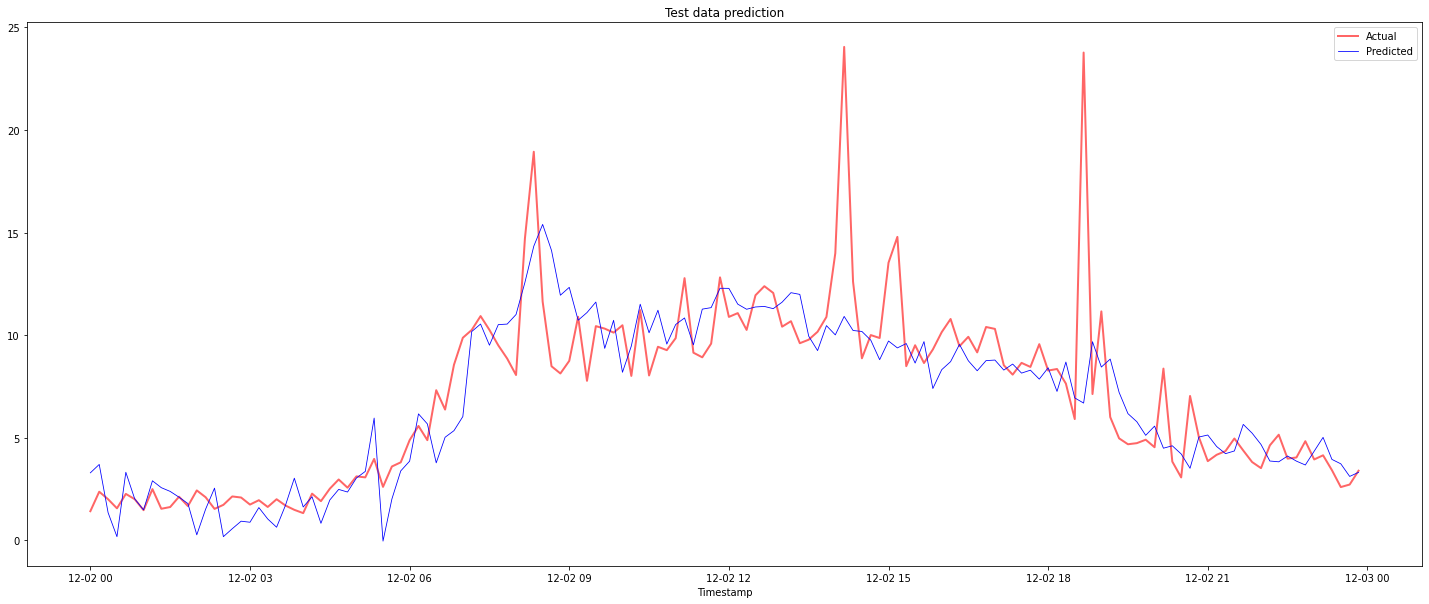

In [ ]:
plt.figure(figsize=(25,10))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Test data prediction")
plt.show()

In [ ]:
predictions=pd.DataFrame(y_test_pred)
predictions.set_index(test_timestamps,inplace=True)
predictions['actual']=y_test
predictions.columns = ['prediction', 'actual']
predictions

,prediction,actual
1,,
2013-12-02 00:00:00,3.294514,1.425484
2013-12-02 00:10:00,3.703536,2.374637
2013-12-02 00:20:00,1.354546,2.008290
2013-12-02 00:30:00,0.183486,1.565345
2013-12-02 00:40:00,3.322671,2.268062
...,...,...
2013-12-02 23:10:00,5.022628,4.148633
2013-12-02 23:20:00,3.948801,3.423748
2013-12-02 23:30:00,3.733916,2.601122


In [ ]:
import sklearn
from sklearn.metrics import mean_absolute_percentage_error
print('MAPE for testing data: ', mean_absolute_percentage_error(y_test,y_test_pred)*100, '%')

MAPE for testing data:  24.837172022157084 %


In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error 
mae=mean_absolute_error(y_test,y_test_pred)
mse=mean_squared_error(y_test,y_test_pred)
rmse=np.sqrt(mse)

print('mae =', mae) #mean absolute error
print('mse  =', mse) #mean square error
print('rmse =', rmse)

mae = 1.4941644315101736
mse  = 6.175514558153351
rmse = 2.485058260514902


## **model without mean feature**

In [ ]:
b = pd.DataFrame(df1[438:8502])
what_day = []
for i in range(8):
  for j in range (7):
    for k in range(144):
      what_day.append(j+1)           #  [1=monday,2=tuesday,3=wednesday,4=thurseday,5=friday,6=saturday,7=sunday]

b['date_no'] = what_day 
#same v as above mentioned                        #___________________________________________________________________cell selection
df4 = b[[v , 'date_no']]
df4

,89,date_no
1,,
2013-11-04 00:00:00,2.078370,1
2013-11-04 00:10:00,1.875145,1
2013-11-04 00:20:00,2.041676,1
2013-11-04 00:30:00,1.905123,1
2013-11-04 00:40:00,1.695281,1
...,...,...
2013-12-29 23:10:00,2.001673,7
2013-12-29 23:20:00,1.855094,7
2013-12-29 23:30:00,1.895097,7


In [ ]:
#timesteps is the sam
#tr_len is the same
train = df4[v][:tr_len].values #6weeks
train = train.reshape(len(train),1)
test = df4[v][tr_len-timesteps+1:tr_len+144].values #1day
test = test.reshape(len(test),1)
print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (4032, 1)
Test data shape:  (288, 1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler_1 = MinMaxScaler()
train = scaler_1.fit_transform(train)
test = scaler_1.transform(test)

In [ ]:
train_data = train
test_data = test

x_train, y_train = train_test_set_setting(train_data,timesteps)
x_test, y_test = train_test_set_setting(test_data,timesteps)

(3888, 144) (3888, 1)
(144, 144) (144, 1)


In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

grid = SVR(kernel='rbf',gamma=1, C=10000, epsilon = 0.01)
grid.fit(x_train, y_train)

SVR(C=10000, epsilon=0.01, gamma=1)

In [ ]:
y_test_pred = grid.predict(x_test)
y_test_pred = y_test_pred.reshape(-1,1) 

test_timestamps = df4[tr_len:tr_len+144].index

In [ ]:
y_test = scaler_1.inverse_transform(y_test)
y_test_pred = scaler_1.inverse_transform(y_test_pred)

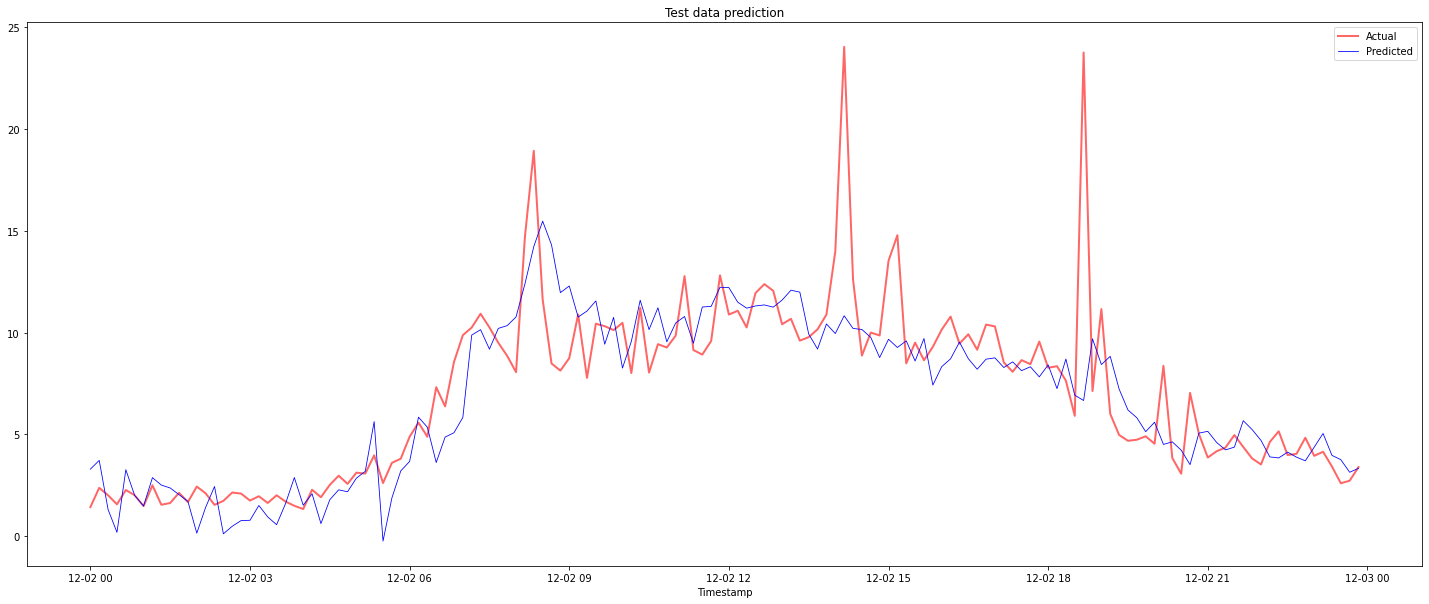

In [ ]:
plt.figure(figsize=(25,10))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Test data prediction")
plt.show()

In [ ]:
import sklearn
from sklearn.metrics import mean_absolute_percentage_error
print('MAPE for testing data: ', mean_absolute_percentage_error(y_test,y_test_pred)*100, '%')

MAPE for testing data:  25.41060045843706 %


In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error 
mae=mean_absolute_error(y_test,y_test_pred)
mse=mean_squared_error(y_test,y_test_pred)
rmse=np.sqrt(mse)

print('mae =', mae) #mean absolute error
print('mse  =', mse) #mean square error
print('rmse =', rmse)

mae = 1.5192035906069339
mse  = 6.293984603138135
rmse = 2.5087814976873006


## **model 3**

In [ ]:
days=[]

mean=[]
for j in range(144):
  loop=[]
  for i in range(8): # 56 days
    z=df4[v][(i*1008)+j:1+(i*1008)+j][0]
    loop.append(z)
  days.append(loop)

df5=pd.DataFrame(np.array(days))
df5

,0,1,2,3,4,5,6,7
0,2.078370,1.198998,1.335551,1.991647,1.425484,1.468795,1.898406,2.477904
1,1.875145,0.985848,4.413202,1.438818,2.374637,1.705207,1.258953,1.575371
2,2.041676,1.258953,1.305574,0.905941,2.008290,1.785213,1.731876,1.638635
3,1.905123,1.075780,1.412149,1.335551,1.565345,1.225667,1.838451,1.092423
4,1.695281,1.825117,1.625300,1.055828,2.268062,2.024933,1.169021,1.871737
...,...,...,...,...,...,...,...,...
139,2.667794,1.948335,2.997447,3.656851,4.148633,3.497236,3.796911,1.611966
140,2.974186,2.581170,2.101531,2.870919,3.423748,3.789003,2.614556,2.554502
141,2.857585,3.840024,2.038268,2.597813,2.601122,2.880945,2.427974,2.008290
142,3.207289,2.597813,1.455461,3.123974,2.724341,2.564527,1.878454,1.765162
